# Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 一、案例简介

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 二、作业说明

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 三、数据概览

本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列Id，标识了每一个测试的样例。

## 四、比赛提交格式

课程页面：https://aistudio.baidu.com/aistudio/education/dashboard

提交文件需要对测试集中每一条评论给出预测为高质量的概率，每行包括一个Id（和测试集对应）以及预测的概率Predicted（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
Id,Predicted
0,0.9
1,0.45
2,0.78
...
```
命名为`result.csv`

**注意除了提交比赛，还需要像之前作业一样在学堂在线提交代码和报告（不包括数据）**


---
---
# <center>实验报告：基于集成学习的 Amazon 用户评论质量预测</center>

## 1 数据预处理
### 1.1 数据集加载与概览

In [11]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing, tree, ensemble, svm, metrics, calibration
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text
# from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from itertools import combinations
from sklearn.utils import shuffle
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import math
import shap
import nltk


In [1]:
import numpy as np
import pandas as pd


In [2]:
train_df = pd.read_csv('../data/train.csv', sep='\t')
test_df = pd.read_csv('../data/test.csv', sep='\t')
train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000


In [3]:
train_df = train_df[:6000]
train_df.shape


(6000, 7)

### 1.2 特征提取

【添加特征】考虑到文本长度将影响文本所携带的信息多少，将【评论长度】，【情感浓度】，【客观性】作为新属性添加进去。

后面绘图过程中，观察到【主观性】受噪点影响较为严重，过于客观和过于主观在正负样本中均有分布，舍弃该指标。

In [4]:
train_df['lenth'] = train_df['reviewText'].map(lambda x:len(x.split(" ")))
train_df['polarity'] = train_df['reviewText'].map(lambda x: TextBlob(x).sentiment[0])
# train_df['subjectivity'] = train_df['reviewText'].map(lambda x: TextBlob(x).sentiment[1])
# train_df.describe()


KeyboardInterrupt: 

【选择特征】通过绘制正负样本对于单一特征的分布图，对特征进行选择。
- 分布基本和总数相同的特征可视为无关，譬如reviewerID/asin，可以删除。
- 统计两种标签的overall，分布不同。
    - 1，5分评价更容易出现低质量
    - 4，5分评价更容易出现高质量

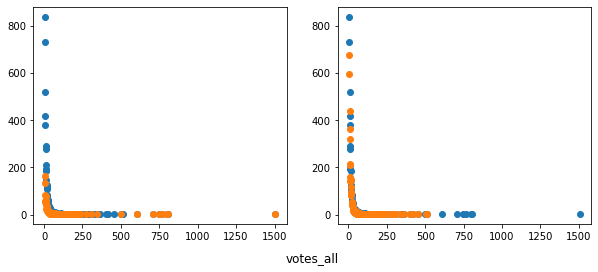

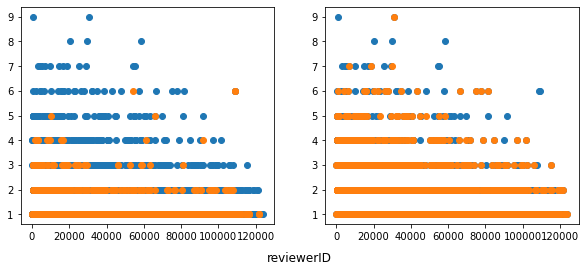

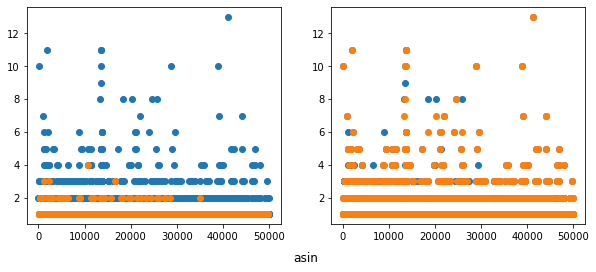

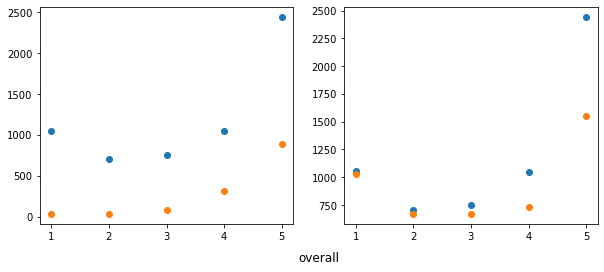

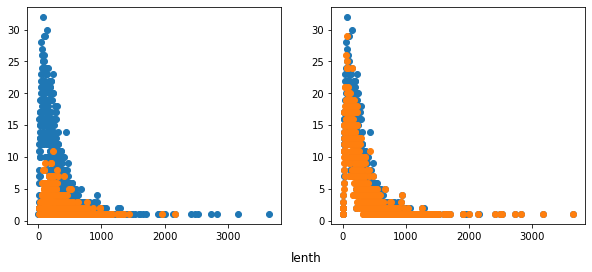

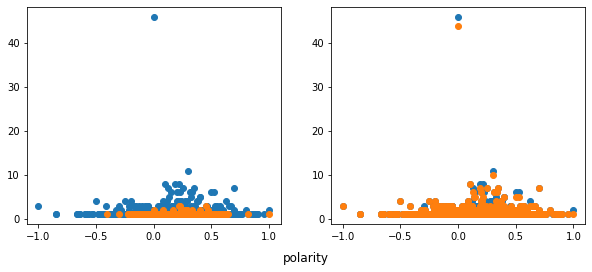

In [12]:
for co in ['votes_all', 'reviewerID', 'asin', 'overall', 'lenth', 'polarity']:
    a = Counter(train_df[co])
    t = Counter(train_df[train_df['label'] == 1][co])
    f = Counter(train_df[train_df['label'] == 0][co])
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(a.keys(), a.values())
    plt.scatter(t.keys(),t.values())
    plt.subplot(122)
    plt.scatter(a.keys(), a.values())
    plt.scatter(f.keys(), f.values())
    plt.title(co, x=-0.1, y=-0.2)
    plt.show()


【特征转化】对于已知有关且在测试集中存在的特征为reviewText，进行向量化处理。

英文NLP相比中文存在一些独特的处理步骤，我们称为词形还原（Lemmatization）和词干提取（Stemming）。
考虑词形还原，将同一个单词的不同形式视作同一个词。

In [55]:
# 未实现，this movie中的 movie 和 movies 并不是同样的出现频率，前者将会有更高的 “正样本 ”率。考虑使用筛选方法。

然后使用词袋模进行特征提取，将正负样本中出现比例差不多的词汇作为停用词。

【特征筛选】
- 最小不加入考虑的阈值来源于测试集大小/训练集大小。按照0.1的可能性出现在测试集中。
- 最小加入停用词差值来源于**两个方面**。
    - 第一方面是文章中出现该词的可能性，使用比率刻画。即$出现该词的文章数/全部文章数$。
    - 另一方面是单篇文章中出现该词的次数。使用均值刻画。即$出现该词的文章中该词出现的总数/出现该词的文章数$。

In [425]:
test_df.shape[0]/train_df.shape[0]

0.19649713354020934

In [13]:
def vectorize(train_data, test_data=None, min_df=0.019, max_df=1.0, max_features=5000, stop_words='english', method='tfidf'):
    if method == 'count':
        cv = CountVectorizer(
            min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words)
    elif method == 'tfidf':
        cv = TfidfVectorizer(min_df=min_df, max_df=max_df,
                             max_features=max_features, stop_words=stop_words, ngram_range=(1, 1))
    cv_model = cv.fit(train_data)
    names = cv_model.get_feature_names()
    features = cv.transform(train_data).toarray()
    feature_lst = []
    feature_lst.append(features)
    # if valid_data:
    #     va_features = cv.transform(valid_data).toarray()
    #     feature_lst.append(va_features)
    if not test_data.empty:
        te_features = cv.transform(test_data).toarray()
        feature_lst.append(te_features)
    return names, feature_lst


names, fea_lst = vectorize(train_df['reviewText'], test_df['reviewText'])
features, te_features = fea_lst[0], fea_lst[1]
print(features.shape, te_features.shape)


(6000, 880) (11208, 880)


In [19]:
# 通过上述两个规则筛选“停用词”，阈值为以100篇正负样本差和概率估计而出
def gen_stop(features, names, occ_thr=0.025, avg_thr=0.5):
    """
    features: trans array from raw vectorize
    names: features extracted from data, tobe selected
    occ_thr: the diff of frenquency of some feature in postive/nagtive is at least [occ_thr]
    avg_thr: the diff of occurrence(single review) of some feature in postive/nagtive is at least [avg_thr] 
    """
    features = pd.DataFrame(features,columns = names)
    pos, neg = features[train_df['label'] ==
                        1], features[train_df['label'] == 0]
    add_stop = []
    for name in names:
        p, n = pos[pos[name] != 0], neg[neg[name] != 0]
        if (abs(p.shape[0]/pos.shape[0] - n.shape[0]/neg.shape[0]) <= occ_thr and
            abs(p[name].sum()/p.shape[0] - n[name].sum()/n.shape[0] <= avg_thr)):
            add_stop.append(name)
    return add_stop



In [20]:
add_stop = gen_stop(features, names, occ_thr=0.04, avg_thr=0.5)
len(add_stop)


798

In [21]:
# 对新增停用词后的数据进行重新向量化
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop)
names, fea_lst = vectorize(train_df['reviewText'], test_df['reviewText'], stop_words=stop_words)
features, te_features = fea_lst[0], fea_lst[1]
print(features.shape, te_features.shape)


(6000, 82) (11208, 82)


绘制词云观察最终筛选出的特征：

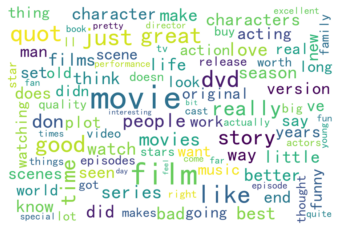

In [5]:
def draw_cloud(features, names, limits_count=100):
    """
    绘制词云，可视化
    """
    df = pd.DataFrame(features, columns=names)
    df.describe()
    word_counts = dict(df.mean())
    # 绘制词云
    my_cloud = WordCloud(
        background_color='white',  # 设置背景颜色  默认是black
        width=900, height=600,
        max_words=limits_count,   # 词云显示的最大词语数量
        font_path='simhei.ttf',   # 设置字体  显示中文
        max_font_size=99,         # 设置字体最大值
        min_font_size=16,         # 设置子图最小值
        random_state=50           # 设置随机生成状态，即多少种配色方案
    ).generate_from_frequencies(word_counts)

    plt.imshow(my_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
draw_cloud(features,names)

此外，观察数据集特征，可得到如下指导意见：
- 测试集与训练集出自iid的数据，所以对应分数出现高质量评论的分布应该也相同，采用如朴素贝叶斯等生成类机器学习方法会更好。同时，基于这点，更倾向于针对欠拟合而非过拟合采取措施。


- 基于比例的预测而不是基于可能性的预测可能带来更好的效果。


- 0.9的阈值对于不同投票个数的评论有着不同的效果。尤其差值为1的情况。在图中也可以看到明显的“线性断点”。即存在某些数据有“发展为错误方”的可能，比如评价7/8很可能是高质量，而5/5也很可能会发展为5/6低质量评论。

### 1.3 数据集划分

将trin_df划分为训练集和验证集，用于参数的调节。

因为后文函数接口只提供了一个，所以此处提交的版本注释了对验证集的使用，即全部训练集都进行训练，以预测测试集。

中间过程为了可视化进行分析，保留的都是验证集上的运行结果，注释后会报错，并非代码自身问题。

In [12]:
def train_test_split(data, test_size=0.3, shuffled=True, random_state=None):
    if shuffled:
        data = shuffle(data, random_state=random_state)
    train = data[int(len(data)*test_size):].reset_index(drop=True)
    test = data[:int(len(data)*test_size)].reset_index(drop=True)
    return train, test

# 为了后面方便，在训练调参的过程中把所有的验证集也写作test_前缀
# train_df, test_df = train_test_split(train_df)


## 2 模型构建
### 2.1 基分类器

下面首先构造数据，然后进行数据归一化。

In [578]:
X_train = np.concatenate(
    [features, train_df[['overall', 'lenth', 'polarity']]], axis=1)
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)

X_test = np.concatenate(
    [te_features, test_df[['overall', 'lenth', 'polarity']]], axis=1)
X_test = preprocessing.MinMaxScaler().fit_transform(X_test)


In [526]:
X_train.shape

(57039, 114)

分别实现 SVM，决策树 和 朴素贝叶斯 三种分类算法，并加入至字典中。其中超参数以【固定值取效果最好的】，【可选值取带来可变性最大的】这两条原则作为标准。

In [714]:
clfs = dict()
clfs['LinearSVM'] = calibration.CalibratedClassifierCV(svm.LinearSVC(loss='squared_hinge', dual=False))
# clfs['SVC'] = svm.SVC(kernel='rbf', probability=True)
clfs['DecisionTree'] = tree.DecisionTreeClassifier(
    criterion='gini', max_depth=5, splitter='random')
clfs['MultBayes'] = MultinomialNB(alpha=1,fit_prior=True,class_prior=[0.8,0.2])
clfs['Knn'] = KNeighborsClassifier(n_neighbors=3)


In [565]:
from sklearn import calibration
for aa in tqdm(range(1)):
    clf = calibration.CalibratedClassifierCV(
        svm.LinearSVC(loss='squared_hinge', dual=False))
    clf.fit(X_train[:10000], train_df['label'][:10000])
    pre =clf.predict(X_train)
    # print(pre[1000:1100])
    print(accuracy_score(pre,train_df['label']))


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

0.7812549308367959


### 2.2 集成框架

实现两种集成框架：
- Bagging：通过多次有返回重复抽样的方式，降低方差，适用于较低偏差的模型。其中，相比于Bagging算法，随机森林通过属性集合中选择子集，来增强基学习器之间的差异性，使得最终集成的学习模型的泛化能力增强。在此处将借鉴这一点思想，对样本和特征都进行随机选择。
- Boosting：通过调整样本权重，根据前一个学习器的训练效果对样本分布进行调整，降低偏差。此处将通过抽样概率的形式提现这一点。

为了使以上两种框架和模型能够以任何形式组件化结合，将集成策略作为单独的上层方法，对多个不同（模型不同/样本不同）分类器进行加权。

In [678]:
# 四种加权算法
def weight(results, labels, weights, y, cls_name, vote_thr=0.5):
    """
    results: proba of each predict (base model)
    labels: label of each predict (base model)
    weights: weight (accuracy, f(e)...) of each predict (base model)
    
    """
    results, labels, weights = np.array(results).T, np.array(labels).T, np.array(weights)
    fig = plt.figure(figsize=(10, 10))
    pres = []
    # 算数平均法
    pre = np.average(results,axis=1)
    pres.append(pre)
    # 加权平均法
    pre = np.dot(results, weights)/np.sum(weights)
    pres.append(pre)
    # 多数投票法
    pre = np.average(labels, axis=1)
    # pre[pre > vote_thr], pre[pre <= vote_thr] = 1, 0
    pres.append(pre)
    # 加权投票法
    pre = np.dot(labels, weights)/np.sum(weights)
    # pre[pre > vote_thr], pre[pre <= vote_thr] = 1, 0
    pres.append(pre)
    # 绘图
    for idx, method in enumerate(['average', ' weight-average', 'vote', 'weight-vote']):
        pre = pres[idx]
        fpr, tpr, thresholds = metrics.roc_curve(y, pre, pos_label=1)
        plt.subplot(2, 2, idx+1)
        plt.plot(fpr, tpr, lw=2)
        auc = metrics.auc(fpr, tpr)
        pre[pre >= 0.5], pre[pre < 0.5] = 1, 0
        acc = accuracy_score(pre, y)
        plt.title('Method: %s    Auc: %.2f    Acc: %.2f' % (method, auc, acc))
        # print('Method: %s    Auc: %.2f    Acc: %.2f' % (method, auc, acc))
    plt.suptitle('Classifier: '+str(cls_name))


Bagging通过训练多个**不同**的弱分类器进行加权，其不同体现于：
- 训练集bootstrap采样
- 特征bootstrap采样

In [687]:
def bagging(base_estimators, datas, n_estimators=10, max_samples=0.1, max_features=0.5):

    assert (n_estimators>0 and max_samples>0 and max_features>0)
    """
    base_estimators: list of models, may same or different
    datas: trainX, trainy, testX, testy
    n_estimators: the num of per base_estimator, not total
    max_samples: float. The proportion of the sample
    max_features:  float. The proportion of the features
    
    """

    results, labels, weights = [], [], []
    s0, s1 = datas[0].shape[0], datas[0].shape[1]
    for clf in base_estimators:
        for i in range(n_estimators):
            sample_lst = random.sample(range(s0), int(max_samples*s0))
            features_lst = random.sample(range(s1), int(max_features*s1))
            clf.fit(datas[0][sample_lst, :]
                    [:, features_lst], datas[1][sample_lst])
            pre = np.array(
                [p[1] for p in clf.predict_proba(datas[2][:, features_lst])])
            results.append(pre)
            # 【存疑】根据比例生成预测标签，而不是根据预测概率
            th = np.sort(pre)[int(0.85*pre.shape[0])]
            # th = 0.5
            pre[pre > th], pre[pre <= th] = 1, 0
            labels.append(pre)
            weights.append([accuracy_score(pre, datas[3])])
            # weights.append([cal_w(pre, datas[3])])
    return results, labels, weights


Adaboost关注于**表现不好**的方面，这里通过增加样本的方法改变权重。GBDT是通过不断拟合负梯度方向（残差）来逼近。

In [694]:
def adaboost(base_estimator, datas, n_estimators=30, learning_rate=1.0, 
                    algorithm='SAMME.R', max_samples=0.05, max_features=1.0):

    assert (n_estimators > 0 and max_samples > 0 and max_features > 0)
    """
    base_estimator: base model, only accept single
    datas: trainX, trainy, testX, testy
    n_estimators: the num of base_estimator, iterations
    learning_rate: the learning rate of algorithm
    【存疑】algorithm: 
        SAMME    cal the models'weight through the proba
        SAMME.R  cal the models'weight through the rate
    max_samples: float. The proportion of the sample
    max_features:  float. The proportion of the features
        
    """
    results, labels, weights = [], [], []
    s0, s1 = datas[0].shape[0], datas[0].shape[1]
    clf = base_estimator
    prob = np.array([1/s0 for n in range(s0)])
    for i in range(n_estimators):
        # 调整样本权重
        sample_lst = random.choices(
            range(s0), weights=prob, k=int(max_samples*s0))
        features_lst = random.sample(range(s1), int(max_features*s1))
        clf.fit(datas[0][sample_lst, :][:, features_lst], datas[1][sample_lst])
        mis_lst = np.array(clf.predict(datas[0][sample_lst, :][:, features_lst])) ^ datas[1][sample_lst]
        err = np.sum(prob[sample_lst][mis_lst==1])
        if err>0.5:
            print('ERROR more than half.')
            break
        prob[sample_lst][mis_lst == 1] *= learning_rate*err/(1-err)
        prob/=np.sum(prob)
        pre = np.array([p[1] for p in clf.predict_proba(datas[2][:, features_lst])])
        results.append(pre)
        # 根据比例生成预测标签，而不是根据预测概率
        th = np.sort(pre)[int(0.8*pre.shape[0])]
        # th = 0.5
        pre[pre > th], pre[pre <= th] = 1, 0
        labels.append(pre)
        weights.append(1/2*math.log((1-err)/err))
    return results, labels, weights


## 3 参数调优

根据上文指导意见的第三条，统计了投票差值的分布情况，最终以14为阈值较有代表性，考虑分类讨论训练两个模型。

在bagging算法中通过组合列举所有可能性的分类模型，在boosting中使用单一模型，调整学习率。

In [648]:
les = np.where(train_df['votes_all'] < 14)[0]
mor = np.where(train_df['votes_all'] >= 14)[0]


100%|██████████| 3/3 [01:02<00:00, 20.86s/it]


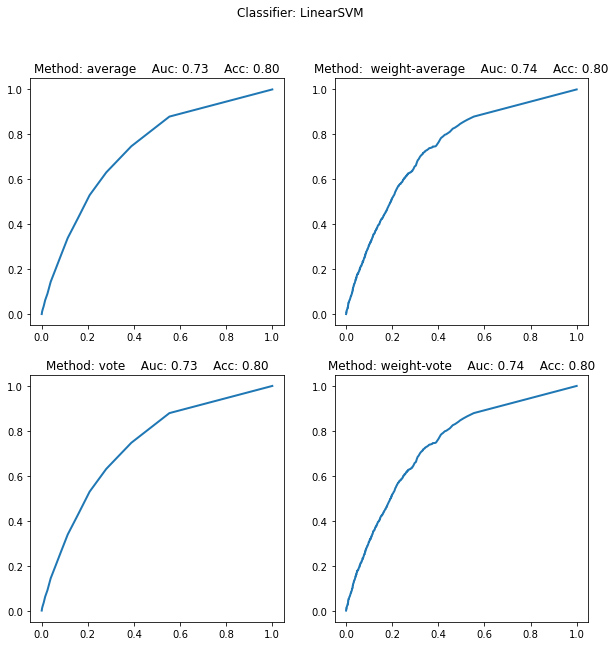

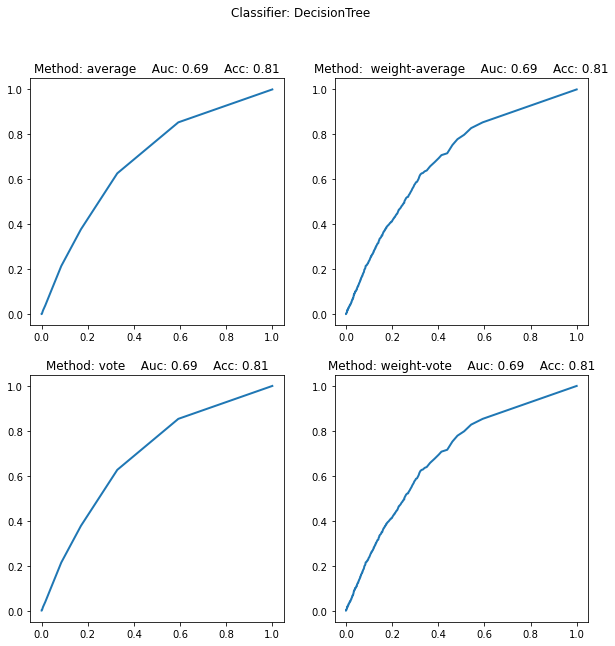

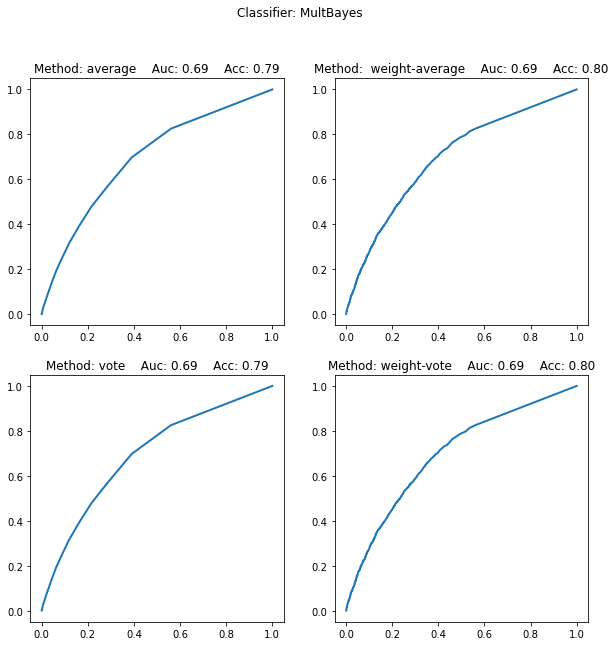

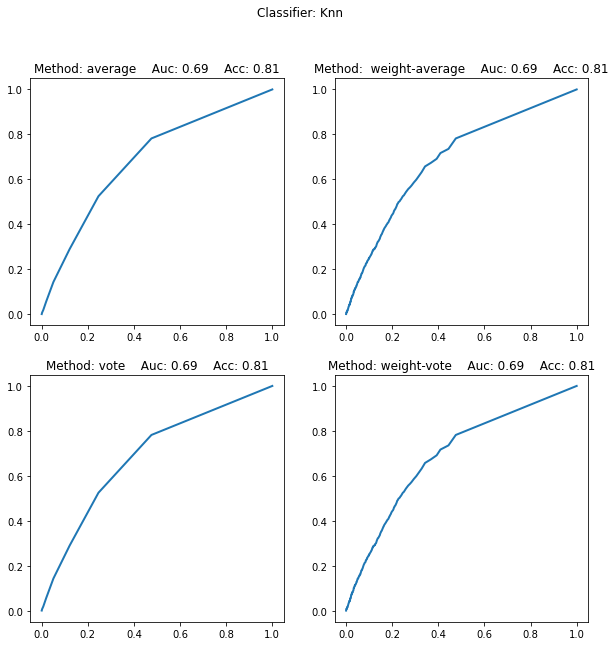

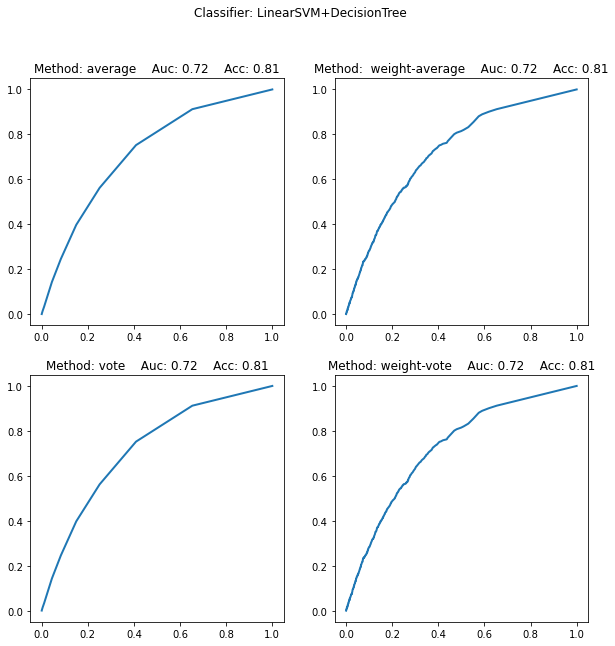

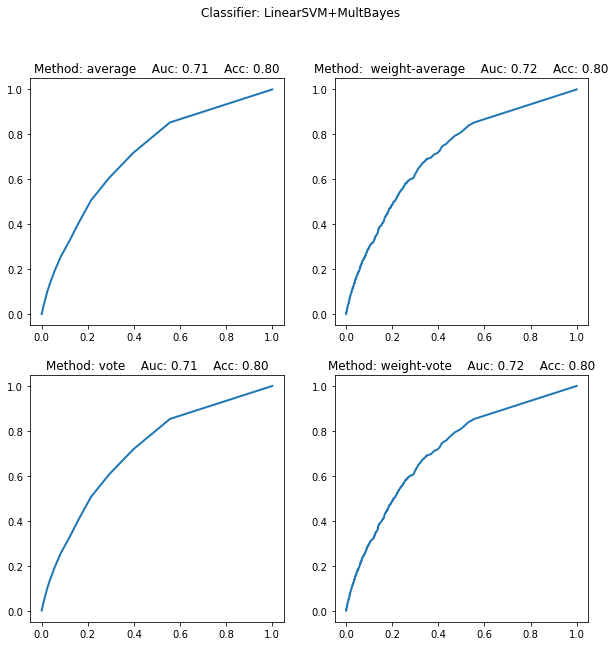

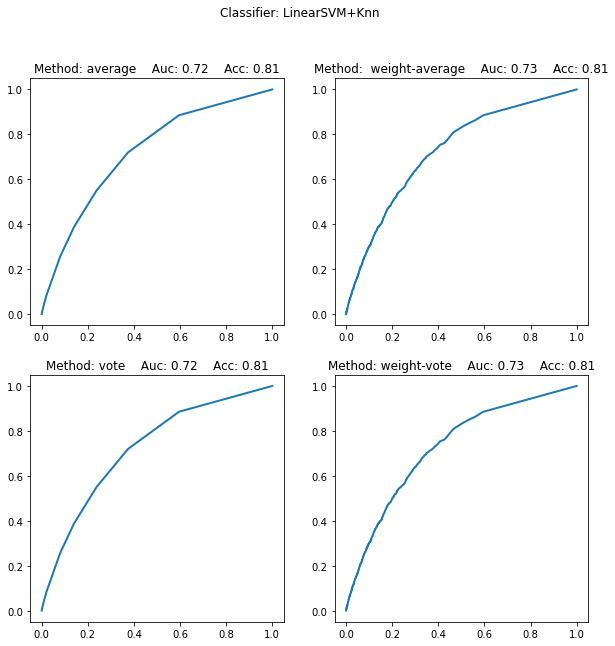

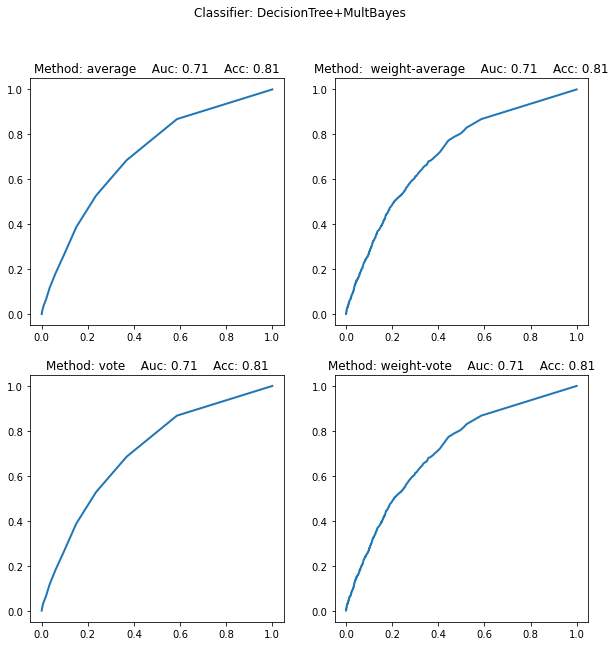

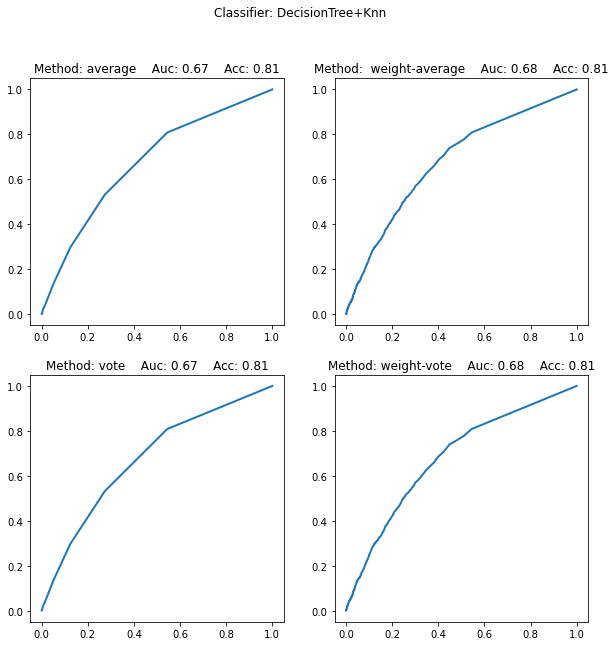

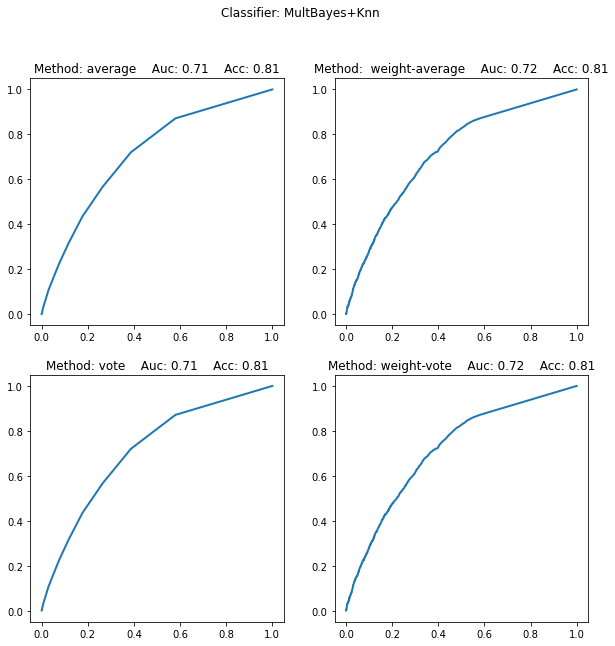

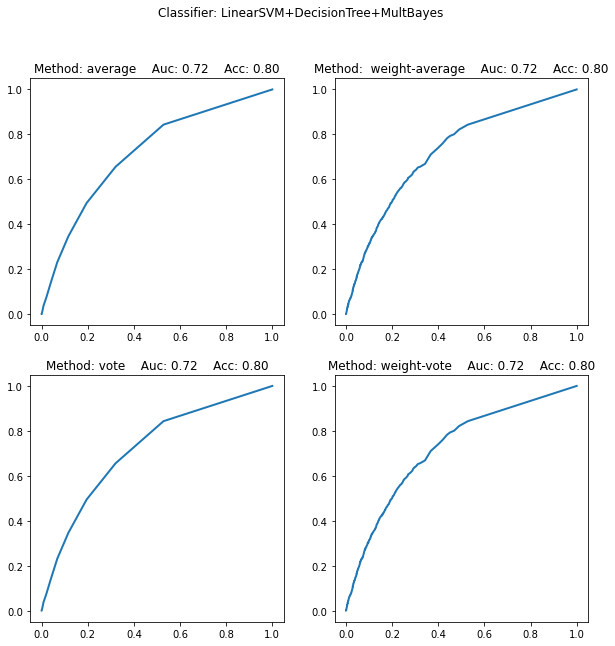

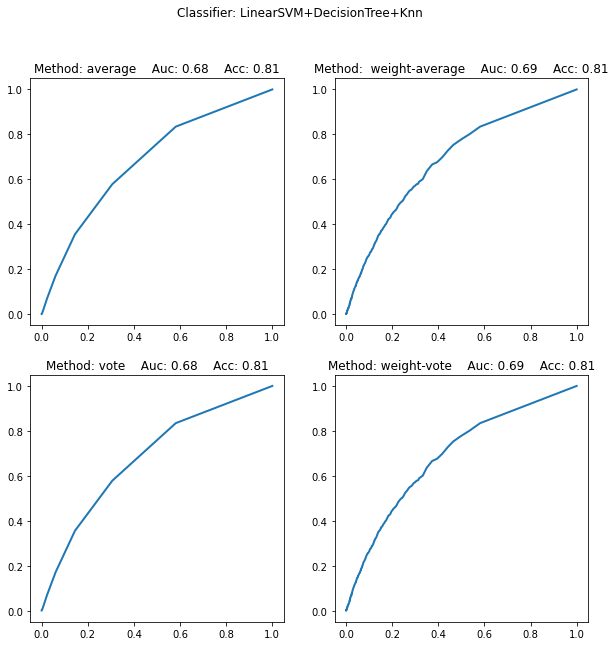

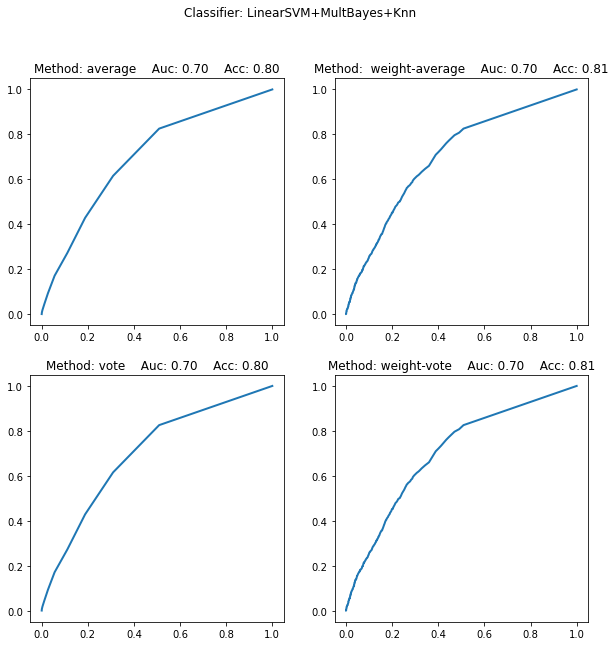

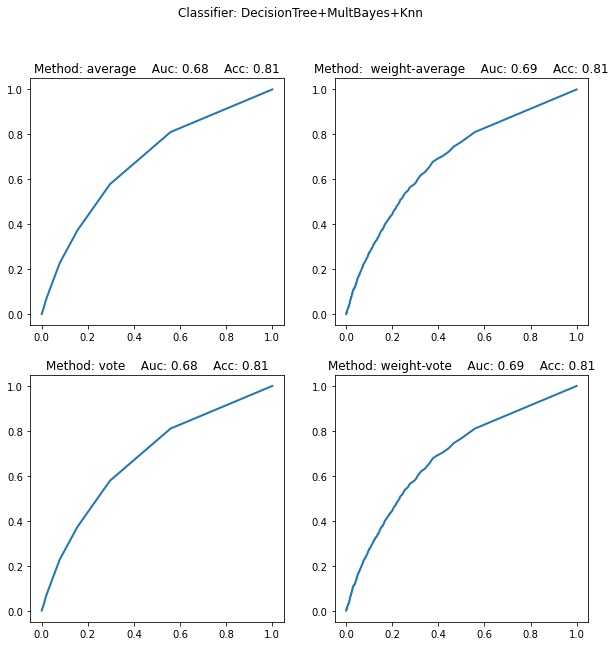

In [717]:
for n in tqdm(range(1, len(clfs))):
    for names in combinations(clfs.keys(), n):
        results, labels, weights = bagging([clfs[name] for name in names], datas=[X_train[les], np.array(
            train_df['label'][les]), X_test, test_df['label']], n_estimators=8//n, 
                                                                        max_samples=0.04, max_features=0.6)
        results_, labels_, weights_ = bagging([clfs[name] for name in names], datas=[X_train[mor], np.array(
            train_df['label'][mor]),  X_test, test_df['label']], n_estimators=8//n, 
                                                                        max_samples=0.01, max_features=0.6)
        results+=results_
        labels+=labels_
        weights+=weights_
        # print(weights)
        weight(results, labels, weights, test_df['label'], '+'.join(names))


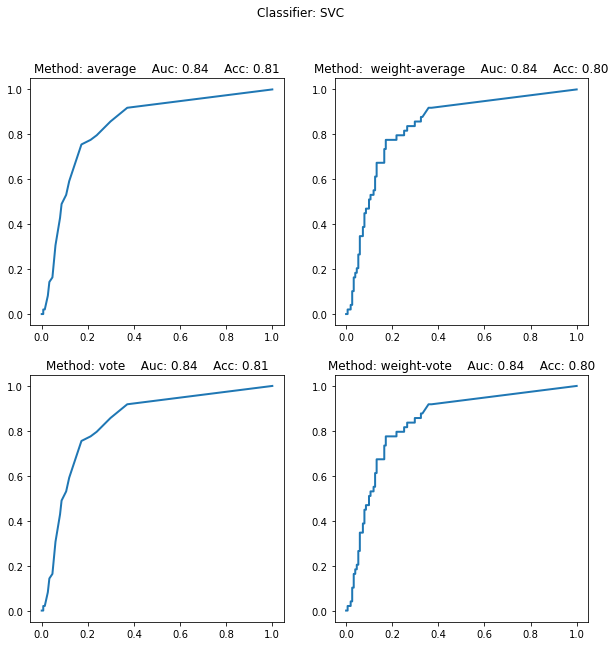

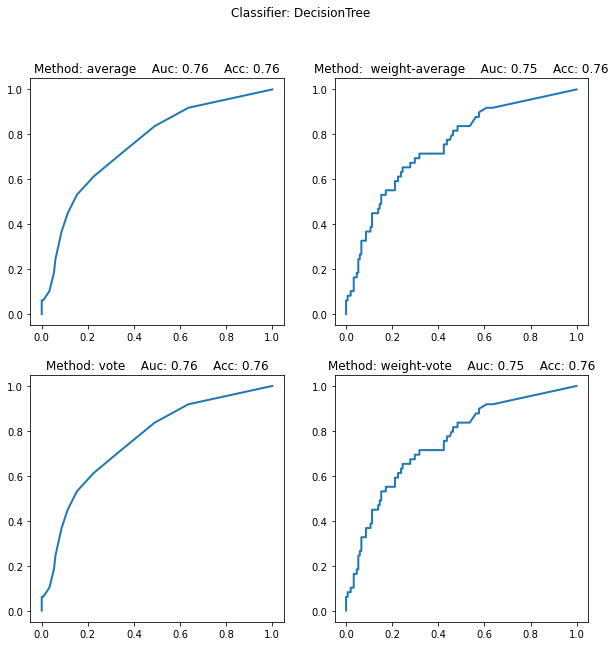

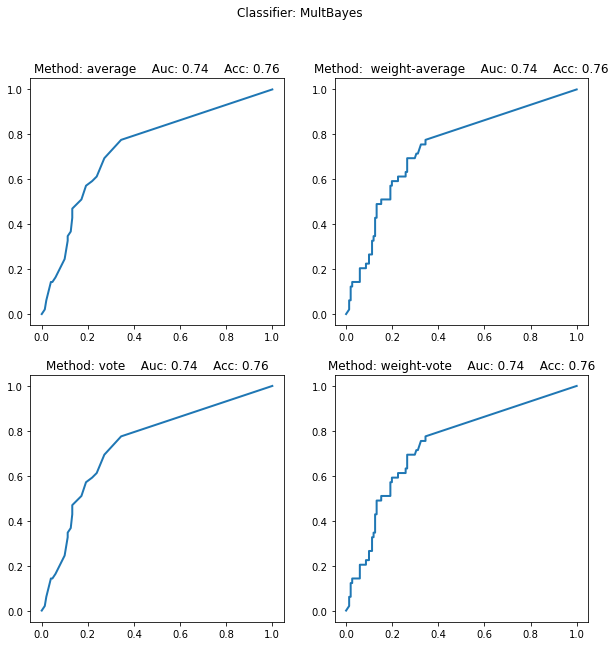

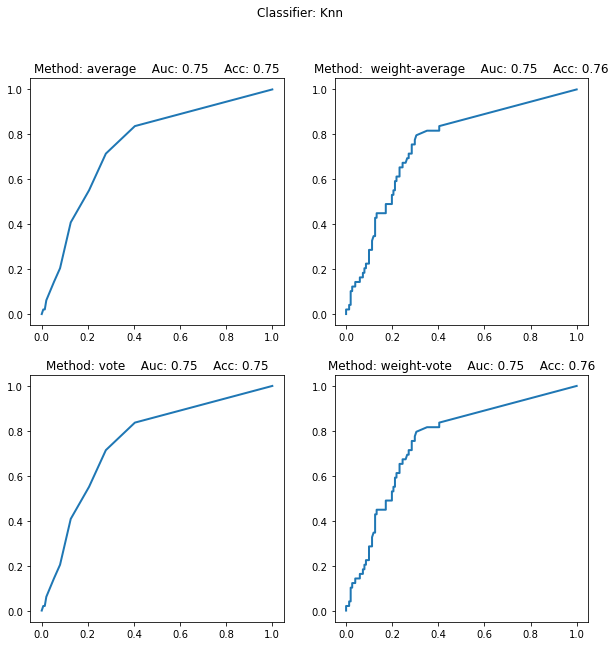

In [408]:
for name, clf in clfs.items():
    results, labels, weights = adaboost(clf, datas=[X_train[les], np.array(
        train_df['label'][les]), X_test, test_df['label']], n_estimators=10, max_samples=1.0, max_features=1.0)
    results_, labels_, weights_ = adaboost(clf, datas=[X_train[les], np.array(
        train_df['label'][les]), X_test, test_df['label']], n_estimators=10, max_samples=1.0, max_features=1.0)
    results += results_
    labels += labels_
    weights += weights_
    # print(weights)
    weight(results, labels, weights,
           test_df['label'], name)


在调优过程中，可以发现，boost对于准确率的提升效果优于bagging，最好的效果(auc)可达0.84。

同时bagging对于【差异性】的要求更高，即模型越不相同，可能获得的效果越好。

## 4 结果

In [314]:
# # 🤭🤭🤭
# test_label = []
# for rt in tqdm(test_df['reviewText']):
#     idx = str.find(rt[:200].replace('\\',r"\\").replace("'", "\'").replace('"','\\"'))
#     if rt == 'Waste of time':
#         test_label.append(0)
#     elif idx == -1:
#         print('[ERROR]:',rt[:200])
#         test_label.append(2)
#     else:
#         h_s = str[idx-1500:idx].rfind('helpful')
#         h_e = str[idx-1500:idx].rfind('reviewText')
#         a = str[idx-1500+h_s+10:idx-1500+h_e-3]
#         (vo_up, vo_all) = map(int, str[idx-1500+h_s+10:idx-1500+h_e-3].strip('[]').split(','))
#         test_label.append(0 if vo_all==0 else vo_up/ vo_all)


100%|██████████| 11208/11208 [3:46:00<00:00,  1.21s/it]


In [354]:
# 提交文件
import csv
with open('./data/result.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id', 'Predicted'])
    for idx,row in enumerate(test_label):
        writer.writerow([idx, row])
